# Feature Importance

## Imports

In [1]:
# import libraries

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import statsmodels
from statsmodels.tsa.stattools import acf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from scipy.stats import jarque_bera
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score

#import functions from scripts folder

sys.path.append('../../scripts')
from fracdiff import *
from labelling import *
from samp_weights import *
from fin_data_management import * 
from fetch_yf_data import fetch_data
from sequential_CV import *
from feature_importance import *
from AFML_book_scripts import *
from AFML_my_scripts import *
from sequential_CV import *

## Experiments with Synthetic Data

We start by focusing on section 8.6.

Here is the pipeline users should follow:

1. Data preparation

We need
- trsnX (X): feature matrix (pd.Dataframe indexed by business days)
- cont (y): pd.Dataframe with:
    - bin: target class (0,1) or (-1,1)
    - w: sample weight (often uniform w_i = 1/N in synth. data)
    - t1: events horizon timestamps for purging/embargoing

X,y = getTestData(n_features=40, n_informative=10, n_redundant=10, n_samples=5000)


2. FI method to use

We have seen MDI, MDA and SFI and you can call one of them:

- MDI --> imp = featImpMDI(fit, featNames=X.columns)
- MDA --> imp, oos = featImpMDA(
    clf, X, cont["bin"], cv=10,
    sample_weight=cont["w"],
    t1=cont["t1"],
    pctEmbargo=0.01,
    scoring="accuracy")
- SFI --> cvGen = PurgedKFold(n_splits=10, t1=cont['t1'], pctEmbargo=0.01)
          imp = auxFeatImpSFI(X.columns, clf, X, cont, scoring="accuracy", cvGen=cvGen)

3. Wrapper function

imp, oob, oos = featImportance(
    trnsX=X,
    cont=cont,
    n_estimators=100,
    cv=10,
    method="MDA",   # or "MDI" / "SFI"
    pctEmbargo=0.01,
    scoring="accuracy")

4. Visualization

plotFeatImportance(
    pathOut="./results",
    imp=imp,
    oob=oob,
    oos=oos,
    method="MDA",
    tag="test",
    simNum=1)

5. Or all together with testfunc

testFunc(
    n_features=40,
    n_informative=10,
    n_redundant=10,
    n_samples=5000,
    n_estimators=200,
    cv=5)

### "Manual" Pipeline

In [2]:
# GET SYNTHETIC DATA

num_features = 20
num_informative = 7
num_redundant = 7
sample_size = 2000

#get X and y
X, y = getTestData(n_features=num_features, n_informative=num_informative, n_redundant=num_redundant, n_samples=sample_size)


In [3]:
# PREPARE THE CLASSIFIERS

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

clf = DecisionTreeClassifier(
    criterion='entropy',
    max_features=1, #--> to avoid masking features each split we pick randomply one feature
    class_weight='balanced', #--> deal with unbalanced labels
    min_weight_fraction_leaf=0
)
clf = BaggingClassifier(
    estimator=clf,
    n_estimators=200,
    max_features=1.,
    max_samples=1.,
    oob_score=True,
    n_jobs=-1
)

In [4]:
# PICK A METHOD AND COMPUTE FI

clf.fit(X, y.bin, sample_weight=y.w.values)
imp = featImpMDI(clf, featNames=X.columns)


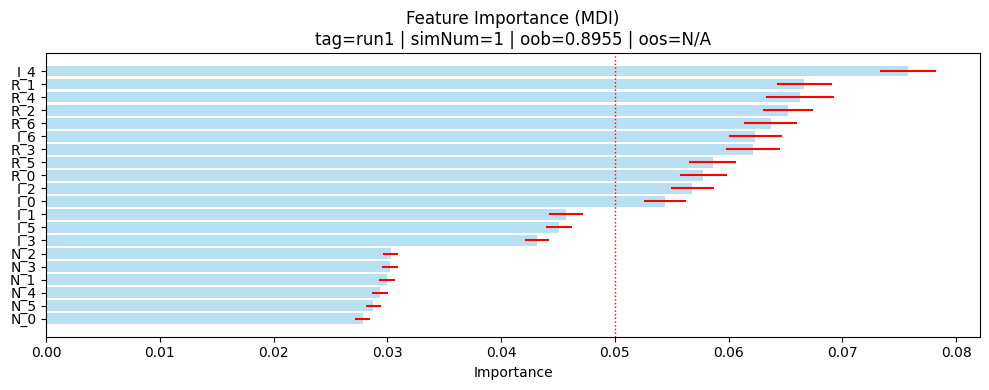

In [6]:
plotFeatImportance(
    pathOut='./results/',
    imp=imp,
    oob=clf.oob_score_,
    oos=oos if 'oos' in locals() else None,
    method='MDI',  # or 'MDI'/'SFI'
    tag='run1',
    simNum=1,
    plot_to_save = False
)

Results for MDI. For each feature, the horizontal bar indicates the mean MDI value across all the decision trees, and the horizontal line is the stan-
dard deviation of that mean. 

Since MDI importances add up to 1, if all features were equally important, each importance would have a value of 1/n_features.
The vertical dotted line separates features whose importance exceeds what would be expected from undistinguishable features. 

MDI does a very good job in terms of placing all informative and redundant features above the red dot-
ted line, with some exceptions, which did not make the cut by a small margin.

Substitution effects cause some informative or redundant features to rank better than others, which was expected.

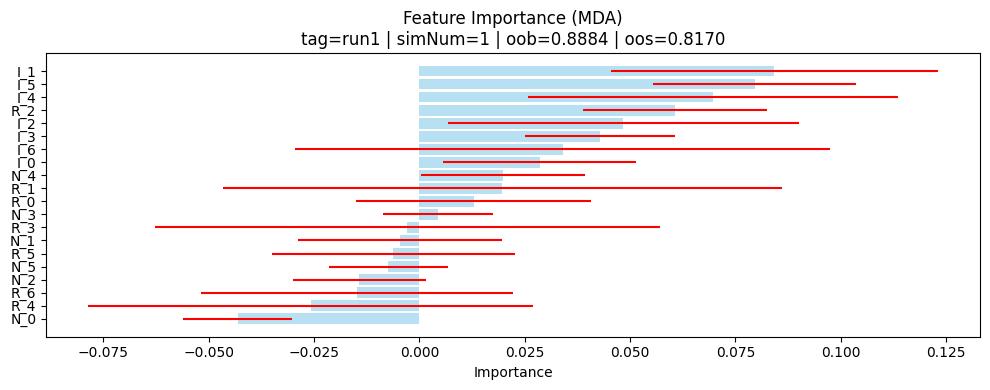

In [8]:
# CHANGE TO MDA AND PLOT AGAIN

imp, oos = featImpMDA(
    clf, X, y.bin, cv=10,
    sample_weight=y.w, t1=y.t1,
    pctEmbargo=0.01, scoring='accuracy'
)

plotFeatImportance(
    pathOut='./results/',
    imp=imp,
    oob=clf.oob_score_,
    oos=oos if 'oos' in locals() else None,
    method='MDA',  # or 'MDI'/'SFI'
    tag='run1',
    simNum=1,
    plot_to_save = False
)

MDA also did a good job. Results are consistent with those from MDI’s in the sense that most of the informed and redundant features rank better than
the noise feature, with the exception likely due to a substitution effect. 

One not so positive aspect of MDA is that the standard deviation of the means are somewhat
higher, although that could be addressed by increasing the number of partitions in
the purged k-fold CV, from, say, 10 to 100 (at the cost of 10 × the computation time
without parallelization).

### Automate with TestFunc

In [9]:
out = testFunc(n_features=20, n_informative=7, n_redundant=7, n_estimators=300,
             n_samples=2000, cv=10, save_csv = False, pathOut="./testFunc/")

Running: MDI_accuracy_0.00_1.0
Running: MDA_accuracy_0.00_1.0
Running: SFI_accuracy_0.00_1.0


In [10]:
out

,method,scoring,minWLeaf,max_samples,I,R,N,oob,oos
1,MDA,accuracy,0.0,1.0,0.486334,-0.072390,-0.083212,0.8935,0.8315
0,MDI,accuracy,0.0,1.0,0.378839,0.442897,0.178264,0.8935,0.8315
2,SFI,accuracy,0.0,1.0,0.344278,0.374055,0.281668,0.8935,0.8315


## Exercises 8.1 to 8.3

In [2]:
#create syn data
X, y = getTestData(n_features=20, n_informative=7, n_redundant=6, n_samples=3000)
#apply PCA transformation
X_pca = orthoFeats(X,0.95)

In [5]:
#parameters
n_estimators = 300
cv = 10
pctEmbargo = 0.01  # 1% embargo

#common args
kwargs = dict(
    n_estimators=n_estimators,
    cv=cv,
    pctEmbargo=pctEmbargo,
    scoring='accuracy',
    minWLeaf=0.)

In [6]:
# --- PCA ---#
# MDI
imp_mdi_pca, oob_mdi_pca, oos_mdi_pca = featImportance(trnsX=X_pca, cont=y, method='MDI', **kwargs)
# MDA 
imp_mda_pca, oob_mda_pca, oos_mda_pca = featImportance(trnsX=X_pca, cont=y, method='MDA', **kwargs)

In [ ]:
# merge X and X_pca and reanalyze
X_union = pd.concat([X,X_pca],axis=1)
# --- UNION --- #
# MDI
imp_mdi_u, oob_mdi_u, oos_mdi_u = featImportance(trnsX=X_union,cont=y, method='MDI', **kwargs)
# MDA 
imp_mda_u, oob_mda_u, oos_mda_u = featImportance(trnsX=X_union, cont=y, method='MDA', **kwargs)


Since PCA automatically removes linearly correlated features and performs a sort "pre-ranking" I am expecting MDI and MDA to output a similar ranking in terms of importances

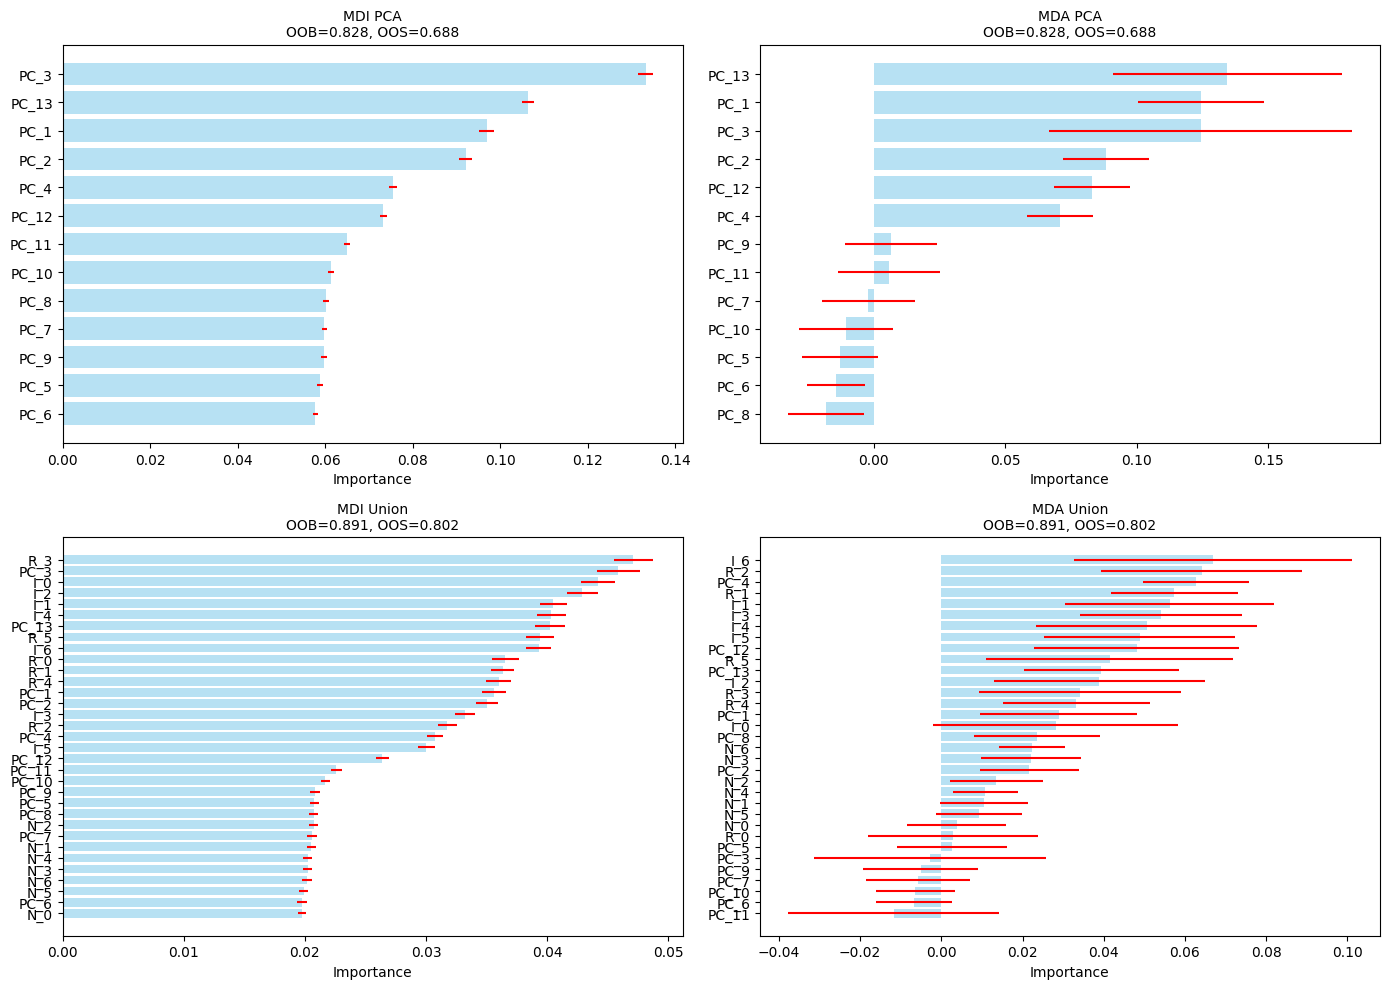

In [8]:
import matplotlib.pyplot as plt

# Prepare list of feature importance data
plots = [
    (imp_mdi_pca, oob_mdi_pca, oos_mdi_pca, "MDI PCA"),
    (imp_mda_pca, oob_mda_pca, oos_mda_pca, "MDA PCA"),
    (imp_mdi_u, oob_mdi_u, oos_mdi_u, "MDI Union"),
    (imp_mda_u, oob_mda_u, oos_mda_u, "MDA Union"),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, (imp, oob, oos, title) in zip(axes, plots):
    imp_sorted = imp.sort_values("mean", ascending=True)
    ax.barh(
        imp_sorted.index,
        imp_sorted["mean"],
        xerr=imp_sorted["std"],
        color="skyblue",
        alpha=0.6,
        ecolor="red"
    )
    ax.set_title(f"{title}\nOOB={oob:.3f}, OOS={oos:.3f}", fontsize=10)
    ax.set_xlabel("Importance")

plt.tight_layout()
plt.show()


**PLOTS IN FIRST ROW** 

Since PCA automatically removes linearly correlated features and performs a pre-ranking based on variance ordering.

- MDI measures impurity reduction at each node split and averages over the entirity of trees in the forest. Since PCs are orth. the split choice is stable
- MDA performs column by column permutations and checks the drop in performance. Since PCs are uncorrelated permutations are quite stable

We expect (and observe) MDI/MDA FIs to be similar

**PLOTS IN SECOND ROW** 

Redundancy and correlation is reintroduced.

- MDI --> orignial features might produce less impurity while PCs do not and they fall in the middle of FIs distribution 
- MDA --> original features permutations might be more performance important and some PCs (correlated) might also be detrimental

In [15]:
# Drop according to MDI and MDA top 10 and reanalyze
X_mdi_worst = X_union.drop(imp_mdi_u[:10].index,axis=1)
X_mda_worst = X_union.drop(imp_mda_u[:10].index,axis=1)


# --- MDI WORST ---#
# MDI
imp_mdi_mdiw, oob_mdi_mdiw, oos_mdi_mdiw = featImportance(trnsX=X_mdi_worst, cont=y, method='MDI', **kwargs)
# MDA 
imp_mda_mdiw, oob_mda_mdiw, oos_mda_mdiw = featImportance(trnsX=X_mdi_worst, cont=y, method='MDA', **kwargs)


# --- MDA WORST ---#
# MDI
imp_mdi_mdaw, oob_mdi_mdaw, oos_mdi_mdaw = featImportance(trnsX=X_mda_worst, cont=y, method='MDI', **kwargs)
# MDA 
imp_mda_mdaw, oob_mda_mdaw, oos_mda_mdaw = featImportance(trnsX=X_mda_worst, cont=y, method='MDA', **kwargs)

In [17]:
imp_mdi_u

,mean,std
I_0,0.044226,0.001401
I_1,0.040509,0.001133
I_2,0.042912,0.001301
I_3,0.033219,0.000799
I_4,0.040354,0.001179
I_5,0.030031,0.000704
I_6,0.039283,0.001024
R_0,0.036552,0.001083
R_1,0.036316,0.000937
R_2,0.031761,0.000811


In [27]:
#drop from imp_mdi_u and imp_mda_u the top 10 features
imp_mdi_u_dropped = imp_mdi_u[10:]
imp_mda_u_dropped = imp_mda_u[10:]
#concat with the new created imp feature to check if rankings stays constant
imp_mdi_merge = pd.concat([imp_mdi_u_dropped['mean'], imp_mdi_mdiw['mean']], axis=1, keys=['old', 'new'])
imp_mda_merge = pd.concat([imp_mda_u_dropped['mean'], imp_mda_mdaw['mean']], axis=1, keys=['old', 'new'])
# Add ranks
imp_mdi_merge['old_rank'] = imp_mdi_merge['old'].rank(ascending=False)
imp_mdi_merge['new_rank'] = imp_mdi_merge['new'].rank(ascending=False)
imp_mda_merge['old_rank'] = imp_mda_merge['old'].rank(ascending=False)
imp_mda_merge['new_rank'] = imp_mda_merge['new'].rank(ascending=False)
#sort by old ranks
imp_mdi_merge = imp_mdi_merge.sort_values('old_rank')
imp_mda_merge = imp_mda_merge.sort_values('old_rank')
#diff in ranks to have an average rank difference
imp_mdi_merge['rank_diff'] = abs(imp_mdi_merge.old_rank - imp_mdi_merge.new_rank)
imp_mda_merge['rank_diff'] = abs(imp_mda_merge.old_rank - imp_mda_merge.new_rank)


In [30]:
avg_mdi_rank_diff = imp_mdi_merge.rank_diff.mean()
avg_mda_rank_diff = imp_mda_merge.rank_diff.mean()
print(f'The average rank differences for MDI-MDA are {round(avg_mdi_rank_diff,2)} and {round(avg_mda_rank_diff,2)}')

The average rank differences for MDI-MDA are 2.09 and 5.57


When removing the top features...

- MDI measures local node impurity reduction --> the left features take over the top ones --> splits are greedy and hierarchical and we expect teh relative rank to stay quite constant
- MDA its permutation based --> removing top features fully changes the predictive structure --> ranking is less stable

Coherent with our average rank differences

## Exercise 8.4

In [ ]:
#starting dataset of 50000 obs
X,y = getTestData(n_features=20,n_informative=5,n_redundant=5,n_samples=50000)

In [52]:
#split in 10 equasized datasets
n_splits = 10
size = len(X) // n_splits

Xs = []
ys = []
for i in range(n_splits):
    start = i*size
    end = (i+1)*size
    Xi = X.iloc[start:end]
    yi = y.iloc[start:end]
    Xs.append(Xi)
    ys.append(yi)

#FI parameters

#parameters
n_estimators = 300
cv = 10
pctEmbargo = 0.01  # 1% embargo

#common args
kwargs = dict(
    n_estimators=n_estimators,
    cv=cv,
    pctEmbargo=pctEmbargo,
    scoring='accuracy',
    minWLeaf=0.)

In [53]:
Xs[i]

,I_0,I_1,I_2,I_3,I_4,R_0,R_1,R_2,R_3,R_4,N_0,N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9
2006-06-28 14:21:54.603750,-0.824973,-1.297600,-0.946321,0.702091,-1.263658,1.236757,0.248698,-1.811914,0.387060,-2.194210,-0.100027,0.877903,0.594660,0.254235,0.218219,2.177102,-0.141392,-0.475477,0.036309,-0.067069
2006-06-29 14:21:54.603750,-1.040220,-1.192242,-0.345395,0.830698,-0.014634,0.135443,-0.309045,-0.429835,-0.579747,-0.573590,0.393580,-0.330360,0.351256,1.066488,-0.346860,1.898313,-1.247645,0.020578,-0.728709,-0.115498
2006-06-30 14:21:54.603750,0.254645,-2.921656,1.394308,0.863404,-1.764733,2.807533,2.213029,0.038324,-0.028609,-0.387059,-0.032942,-0.244851,0.599741,1.424156,1.499987,0.474862,-0.883640,-0.225646,-1.155252,-1.197235
2006-07-03 14:21:54.603750,1.698116,-2.392600,1.463065,1.119833,-3.899981,4.369744,3.330768,-1.340305,1.494836,-1.190359,1.344821,-0.879912,-1.483625,-0.637430,-0.566836,-2.027442,0.431456,0.232442,1.331911,-2.762583
2006-07-04 14:21:54.603750,-1.576776,-1.402637,-1.471716,1.169256,-0.694548,0.535650,-0.593795,-1.957420,-0.175882,-2.219547,1.044514,0.715427,0.764541,-0.483507,1.455449,0.029594,0.056760,-0.584015,-0.597650,0.715946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-20 14:21:54.603750,-1.404686,-1.839365,-0.403870,1.425309,-0.537542,0.532399,-0.208624,-0.936669,-0.571607,-1.057930,-0.613898,-0.058878,1.313482,-0.813327,-1.262450,0.125526,0.068753,0.988193,-0.299930,0.476633
2025-08-21 14:21:54.603750,-1.267052,-0.620814,-2.541547,1.825232,-1.763281,0.789536,-0.985675,-3.686731,0.599335,-3.259693,-0.718595,-0.137200,-0.250589,0.895702,1.030081,-1.497384,0.590683,-0.607886,1.909751,-1.262233
2025-08-22 14:21:54.603750,-1.484554,-2.087209,-1.657805,1.574392,-1.193901,1.352578,-0.266053,-2.407802,-0.231606,-2.608289,0.688223,-0.499994,0.122841,0.526234,0.635326,0.621519,-0.077827,-1.008453,-0.305383,-0.717832
2025-08-25 14:21:54.603750,-0.233580,0.182681,-1.292590,1.343481,-1.241070,0.329014,-0.621806,-2.135905,0.505844,-1.351036,-0.671300,0.276273,-0.848582,-0.204411,-0.179304,-1.309167,0.254070,-0.187988,2.081747,1.065089


In [55]:
#parallelized feature importance (MDI)
imps_mdi = []
imps_mda = []
for i in range(len(Xs)):
    imp_mdi_i, oob_mdi_i, oos_mdi_i = featImportance(trnsX=Xs[i], cont=ys[i], method='MDI', **kwargs)
    print(f'step {i+1}/{len(Xs)} of FI via MDI completed')
    imp_mda_i, oob_mda_i, oos_mda_i = featImportance(trnsX=Xs[i], cont=ys[i], method='MDA', **kwargs)
    print(f'step {i+1}/{len(Xs)} of FI via MDA completed')
    imps_mdi.append(imp_mdi_i)
    imps_mda.append(imp_mda_i)

step 1/10 of FI via MDI completed
step 1/10 of FI via MDA completed
step 2/10 of FI via MDI completed
step 2/10 of FI via MDA completed
step 3/10 of FI via MDI completed
step 3/10 of FI via MDA completed
step 4/10 of FI via MDI completed
step 4/10 of FI via MDA completed
step 5/10 of FI via MDI completed
step 5/10 of FI via MDA completed
step 6/10 of FI via MDI completed
step 6/10 of FI via MDA completed
step 7/10 of FI via MDI completed
step 7/10 of FI via MDA completed
step 8/10 of FI via MDI completed
step 8/10 of FI via MDA completed
step 9/10 of FI via MDI completed
step 9/10 of FI via MDA completed
step 10/10 of FI via MDI completed
step 10/10 of FI via MDA completed


In [ ]:
#average out the parallelized FIs
imp_mdi_avg = (pd.concat(imps_mdi).groupby(level=0).agg({'mean':'mean', 'std':'mean'}))
imp_mda_avg = (pd.concat(imps_mda).groupby(level=0).agg({'mean':'mean', 'std':'mean'}))

In [60]:
#perform the stacked operation of FI
imp_mdi_stack, oob_mdi_stack, oos_mdi_stack = featImportance(trnsX=X, cont=y, method='MDI', **kwargs)
imp_mda_stack, oob_mda_stack, oos_mda_stack = featImportance(trnsX=X, cont=y, method='MDA', **kwargs)
        

Why discrepancy happens (parallelized vs stacked FI)

**Parallelized FI**

Split (X,y) into 10 independent subsamples --> train 10 independent RFs and compute feature importance separately --> then average.

Each RF only sees 1/10th of the data, so the trees are shallower and noisier.
Importance scores vary more across splits because small samples emphasize noise features or understate weaker informative features. Averaging smooths some of this randomness, but not fully.

**Stacked FI (on full dataset)**

The model sees the entire signal and correlation structure.

Importance values are more stable, because variance due to small-sample noise is reduced. Weak informative features that may be “missed” in smaller splits are more likely to get correctly ranked.

Which one is more reliable?

Stacked FI is more reliable --> it uses the full dataset, it produces estimates with lower variance and higher statistical power.

Parallelized FI can be useful when 
- The dataset is too big to fit in memory.
- Study robustness (how consistent importances are across subsamples).
- Exploring stability (rank variability across splits is informative).

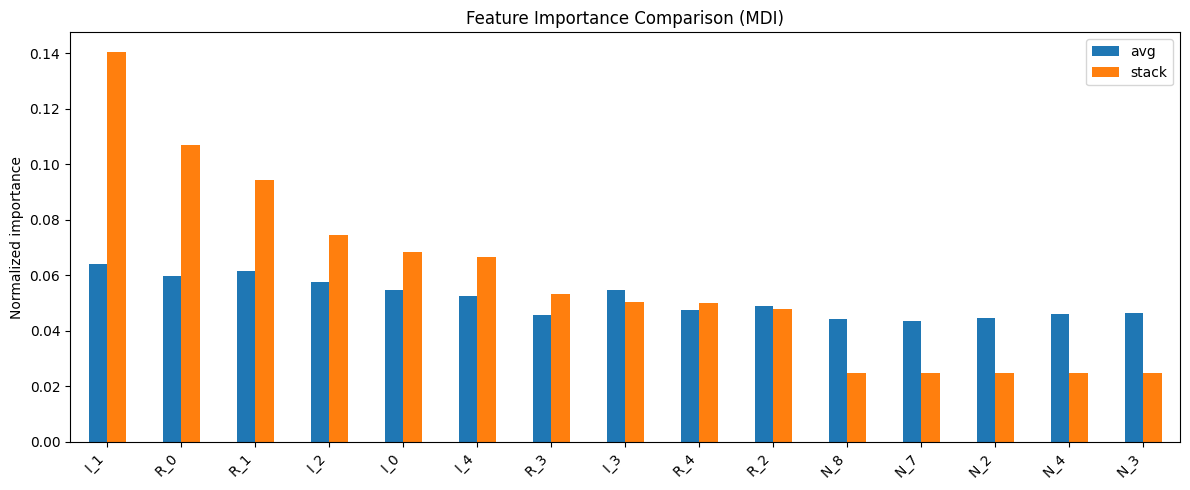

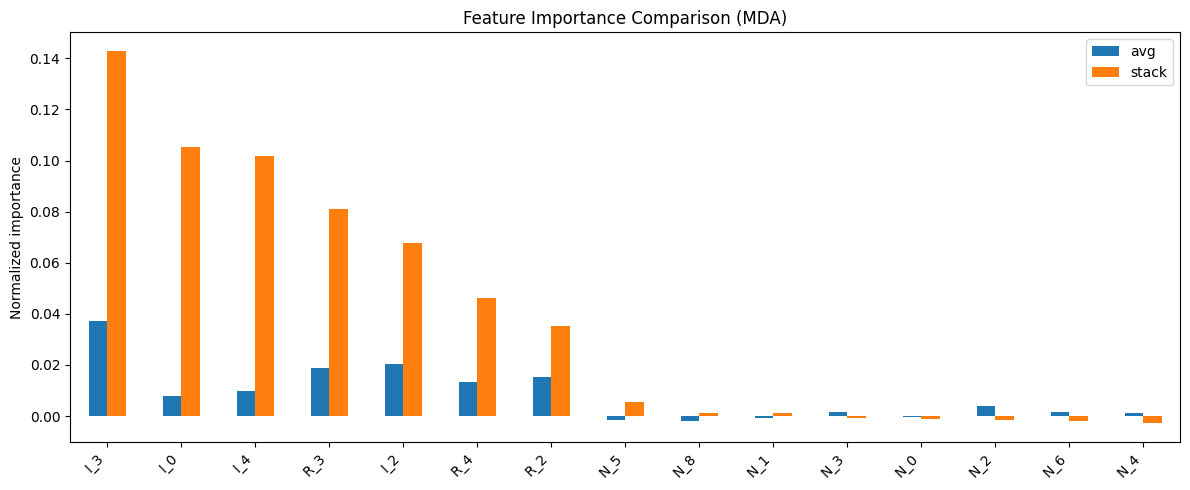

In [63]:
def compare_importances(imp_avg, imp_stack, method="MDI", topn=15):
    """
    Compare averaged vs stacked feature importance visually.
    imp_avg and imp_stack must be DataFrames with a 'mean' column.
    """
    df = pd.concat(
        [imp_avg['mean'].rename('avg'), imp_stack['mean'].rename('stack')],
        axis=1
    )

   

    # sort by stacked importance (more reliable)
    df = df.sort_values("stack", ascending=False).head(topn)

    # plot
    ax = df.plot(kind="bar", figsize=(12, 5))
    ax.set_title(f"Feature Importance Comparison ({method})")
    ax.set_ylabel("Normalized importance")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# --- Usage ---
compare_importances(imp_mdi_avg, imp_mdi_stack, method="MDI")
compare_importances(imp_mda_avg, imp_mda_stack, method="MDA")


What we observe:

**MDI**

- The FIs distribution is more flat in the case of parallelizzation due to averaging on subsample. The model does not see all teh data at once --> this was expected

**MDA**

- The FIs distirbution is much bigger in magnitude in the stacked analysis due to the bigger amount of data --> on bigger subsets permutation infers bigger performances changes giving a larger FI magnitude